# Analyse der Tweets von Bundestagsabgeordneten
## 1. Dataset preparation

In [1]:
import pymongo

client = pymongo.MongoClient("mongodb://localhost:27017/")

db = client['Twitter']
All_Tweets_collection = db['twitter_mdp_ex_date_proj']


In [2]:
import pandas as pd
import numpy as np
import pymongo
import datetime

pd.set_option('display.max_colwidth', 0)

# sample_df = pd.DataFrame(list(All_Tweets_collection.aggregate([ {"$sample": {"size": 50 }}], 
#                                      allowDiskUse=True
#                                    )))

time_sample_df = pd.DataFrame(list(All_Tweets_collection.find( {
            'created_at_datetime': {'$gte': datetime.datetime(2020,5,1,0,0,0),
                                    '$lt': datetime.datetime(2020,5,2,0,0,0)},
            'retweeted_id': None
            })
        ))# Load the regular expression library
pd.set_option('display.max_colwidth', 0)

import re

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F900-\U0001F9FF"  # https://www.compart.com/de/unicode/block/U+1F900
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

sample_df = time_sample_df
# Remove punctuation
sample_df.loc[:,('full_text_processed')] = sample_df.loc[:,('full_text')].map(lambda x: re.sub('[,\.!?#@\\n"“„\:;&\(\)]', '', x))
# Remove Links
sample_df.loc[:,('full_text_processed')] = sample_df.loc[:,('full_text_processed')].map(lambda x: re.sub('http.*', '', x))

sample_df.loc[:,('full_text_processed')] = sample_df.loc[:,('full_text_processed')].map(lambda x: re.sub('amp', '', x))
# Convert the titles to lowercase
#sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: x.lower())

#sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: remove_emoji(x))
# Print out the first rows of papers
#sample_df['full_text_processed'].head(200)

sample_df = sample_df[sample_df['full_text_processed'] != '']
sample_df = sample_df[sample_df['full_text_processed'] != ' ']
sample_df = sample_df[sample_df['full_text_processed'] != '   ']

In [3]:
date = []
for timestamp in sample_df.created_at_datetime:
    date.append(timestamp.date())
      
sample_df.loc[:, ('date')] = date
sample_df.loc[:,('month')] = sample_df.created_at_datetime.dt.strftime('%y-%m')
sample_df.loc[:,('week')] = sample_df.created_at_datetime.dt.strftime('%y-w%V')

# Features
Code von TUWien angepasst für die Anwendung auf eigene Tweets

In [4]:
sample_mdp = np.array(sample_df['full_text_processed'])

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

import pickle, gensim, numpy as np

from utilities import get_train_data, get_test_data, Tokenizer, find_subtoken

PICKLE_FOLDER_PATH = '/home/lisa/Darmstadt/Master Arbeit/06_Analyse/'

TRAIN_FILENAME = '/home/lisa/Darmstadt/Master Arbeit/06_Analyse/germeval2018.training.txt'
#mdp = '/home/lisa/Darmstadt/Master Arbeit/06_Analyse/mdp_tweets.txt'

#------------------------------
#source:
#http://www.cl.uni-heidelberg.de/english/research/downloads/resource_pages/GermanTwitterEmbeddings/GermanTwitterEmbeddings_data.shtml
MODEL_FILENAME  = "/home/lisa/Darmstadt/Master Arbeit/06_Analyse/twitter-de_d100_w5_min10.bin" # 821,8 MB
MODEL_DIMENSION = 100

In [6]:
%%time
word2vec_model  = gensim.models.KeyedVectors.load_word2vec_format(MODEL_FILENAME, binary=True)

X_train, y_train_t1, y_train_t2 = get_train_data(TRAIN_FILENAME)
X_test_mdp                      = sample_mdp

CPU times: user 10.1 s, sys: 836 ms, total: 10.9 s
Wall time: 11 s


In [7]:
print(len(X_train))
print(len(X_test_mdp))
# 5009
# 11636

5009
509


### NGRAM FEATURES
 * Erstelle n-Gramme mit 3-7 Buchstaben (Funktion: char_vect)
 * Erstelle n-Gramme mit 1-3 Wörtern /Funkion: token_vect
 * Anwendung auf Training/ Test und mdp Daten

In [8]:
char_vect  = TfidfVectorizer(analyzer="char", ngram_range=(3, 7), max_df=0.01, min_df=0.0002,
                             preprocessor=Tokenizer(preserve_case=False, join=True).tokenize)

token_vect = TfidfVectorizer(analyzer="word", ngram_range=(1, 3), max_df=0.01, min_df=0.0002,
                             tokenizer=Tokenizer(preserve_case=False, use_stemmer=True).tokenize)

X_CNGR_train = char_vect.fit_transform(X_train)
X_CNGR_mdp = char_vect.transform(X_test_mdp)

X_TNGR_train = token_vect.fit_transform(X_train)
X_TNGR_mdp  = token_vect.transform(X_test_mdp)

In [9]:
pickle.dump(X_CNGR_train, open(PICKLE_FOLDER_PATH + "X_CNGR_train.p", "wb" ))
pickle.dump(X_CNGR_mdp,  open(PICKLE_FOLDER_PATH + "X_CNGR_mdp.p", "wb" ))

pickle.dump(X_TNGR_train, open(PICKLE_FOLDER_PATH + "X_TNGR_train.p", "wb" ))
pickle.dump(X_TNGR_mdp, open(PICKLE_FOLDER_PATH + "X_TNGR_mdp.p", "wb" ))

In [10]:
print(X_CNGR_train.shape)
print(X_CNGR_mdp.shape)
print(X_TNGR_train.shape)
print(X_TNGR_mdp.shape)
# (5009, 207575)
# (11636, 207575)
# (5009, 20082)
# (11636, 20082)

(5009, 207575)
(509, 207575)
(5009, 20082)
(509, 20082)


### EMB FEATURES
* Tweets werden in Token unterteilt
* Prüfe ob die Token in einem Token im vortrainierten word2vec Model entsprechen
* Wenn nicht, teile Token in Präfix und Suffix und prüfe für diese das word2vec Model (ggf. beide in emb)
* emb enthält pro Tweet Vektoren für Token und wird normalisiert mit der Länge des Tweets + ggf extra Tokens
* X_EMB enthält die normalisierten Vektoren pro Tweet

In [11]:
def get_EMB_feats(tweets):   
    tknzr = Tokenizer(preserve_case=True)
    tweets = [tknzr.tokenize(tweet) for tweet in tweets]
    
    X_EMB = []

    for tweet, i in zip(tweets, range(0,len(tweets))):
        emb = np.zeros(MODEL_DIMENSION)
        extra_tokens = 0
        
        for token in tweet:
            try:
                emb += word2vec_model[token]
            except:
                prefix = find_subtoken(token, word2vec_model, mode='initial')
                suffix = find_subtoken(token, word2vec_model, mode='final')
                    
                if prefix != None and suffix != None:
                    emb += word2vec_model[prefix] + word2vec_model[suffix]
                    extra_tokens += 1
                elif prefix != None and suffix == None:
                    emb += word2vec_model[prefix]
                elif prefix == None and suffix != None:
                    emb += word2vec_model[suffix]           
        emb /= (len(tweet) + extra_tokens)
#         print(i)
#         print(len(tweet))
        X_EMB.append(emb)
        
    return normalize(X_EMB)

In [12]:
len(X_test_mdp)
# #5658
# X_test_mdp[5600:]

509

In [13]:
%%time
X_EMB_train = get_EMB_feats(X_train)
X_EMB_mdp  = get_EMB_feats(X_test_mdp)

CPU times: user 887 ms, sys: 8.18 ms, total: 895 ms
Wall time: 883 ms


In [14]:
print(X_EMB_train.shape)
print(X_EMB_mdp.shape)
# (5009, 100)
# (11636, 100)

(5009, 100)
(509, 100)


In [15]:
pickle.dump(X_EMB_train, open(PICKLE_FOLDER_PATH + "X_EMB_train.p", "wb" ))
pickle.dump(X_EMB_mdp,  open(PICKLE_FOLDER_PATH + "X_EMB_mdp.p", "wb" ))

### TIMP FEATURES
* Finden der wichtigen Tokens - also derer die in Tweets der angegebenen Kategorie verwendet werden
* Für diese wichtigsten Tokens werden die Features analog der EMB Features aus dem word2vec model abgeleitet
* Außerdem werden für alle Tweets analog der EMB feats abgeleitet
* Vergleiche mit der Cosine Similarity und gebe die höchsten und niedrigsten Werte pro Tweet zurück


In [16]:
def k_most_imp_tokenlvl(k, category, max_df=0.01, min_df=0.0002):      
    token_vect = TfidfVectorizer(analyzer="word", ngram_range=(1, 1), lowercase=False,
                                 max_df=max_df, min_df=min_df,
                                 tokenizer=Tokenizer(preserve_case=True).tokenize)
    
    tfidf = token_vect.fit_transform(X_train)
    
    vocab = token_vect.vocabulary_
    inv_vocab = {index: word for word, index in vocab.items()}
    
    if category in ['OTHER', 'OFFENSE']:
        cat_ids = np.where(y_train_t1 == category)
    elif category in ['PROFANITY', 'ABUSE', 'INSULT']:
        cat_ids = np.where(y_train_t2 == category)
        
    most_imp_ids = np.argsort(np.asarray(np.mean(tfidf[cat_ids], axis=0)).flatten())[::-1]
        
    most_imp = []
    for index in most_imp_ids:
        most_imp.append(inv_vocab[index])

    return most_imp[:k]

def get_TIMP_feats(tweets, k, category, max_df=0.01, min_df=0.0002):
    feats_max = []
    feats_min = []
           
    imp_tokens_vectors = []
    for imp_token in k_most_imp_tokenlvl(k, category, max_df=max_df, min_df=min_df):
        try:
            imp_tokens_vectors.append(word2vec_model[imp_token])
        except:
            imp_tokens_vectors.append(np.zeros(MODEL_DIMENSION))
    
    tknzr = Tokenizer(preserve_case=True)
    tweets = [tknzr.tokenize(tweet) for tweet in tweets]
    
    for tweet in tweets:
        tweet_vectors = []
        for token in tweet:
            try:
                tweet_vectors.append(word2vec_model[token])
            except:
                prefix = find_subtoken(token, word2vec_model, mode='initial')
                suffix = find_subtoken(token, word2vec_model, mode='final')
                 
                if prefix != None and suffix != None:
                    tweet_vectors.append(word2vec_model[prefix])
                    tweet_vectors.append(word2vec_model[suffix])
                elif prefix != None and suffix == None:
                    tweet_vectors.append(word2vec_model[prefix])
                elif prefix == None and suffix != None:
                    tweet_vectors.append(word2vec_model[suffix])
                else:
                    tweet_vectors.append(np.zeros(MODEL_DIMENSION))
                    
        similarity = cosine_similarity(np.asarray(tweet_vectors), np.asarray(imp_tokens_vectors))
        
        feats_max.append(np.amax(similarity, axis=0))
        feats_min.append(np.amin(similarity, axis=0))
        
    return np.concatenate((feats_max, feats_min), axis=1)

In [17]:
%%time
N_TIMP_TASK1 = 1250
N_TIMP_TASK2 = 170

X_TIMP_task1_train = \
np.concatenate((get_TIMP_feats(X_train, N_TIMP_TASK1, 'OTHER'),
                get_TIMP_feats(X_train, N_TIMP_TASK1, 'OFFENSE')), axis=1)


# X_TIMP_task2_train = \
# np.concatenate((get_TIMP_feats(X_train, N_TIMP_TASK2, 'OTHER'),
#                 get_TIMP_feats(X_train, N_TIMP_TASK2, 'ABUSE'),
#                 get_TIMP_feats(X_train, N_TIMP_TASK2, 'INSULT'),
#                 get_TIMP_feats(X_train, N_TIMP_TASK2, 'PROFANITY')), axis=1)

X_TIMP_task1_mdp = \
np.concatenate((get_TIMP_feats(X_test_mdp,  N_TIMP_TASK1, 'OTHER'),
                get_TIMP_feats(X_test_mdp,  N_TIMP_TASK1, 'OFFENSE')), axis=1)

# X_TIMP_task2_mdp = \
# np.concatenate((get_TIMP_feats(X_test_mdp,  N_TIMP_TASK2, 'OTHER'),
#                 get_TIMP_feats(X_test_mdp,  N_TIMP_TASK2, 'ABUSE'),
#                 get_TIMP_feats(X_test_mdp,  N_TIMP_TASK2, 'INSULT'),
#                 get_TIMP_feats(X_test_mdp,  N_TIMP_TASK2, 'PROFANITY')), axis=1)


CPU times: user 38.6 s, sys: 532 ms, total: 39.1 s
Wall time: 20.9 s


In [18]:
print(X_TIMP_task1_train.shape)
print(X_TIMP_task1_mdp.shape)
# (5009, 5000)
# (11636, 5000)

(5009, 5000)
(509, 5000)


In [19]:
pickle.dump(X_TIMP_task1_train, open(PICKLE_FOLDER_PATH + "X_TIMP_task1_train.p", "wb" ))
# pickle.dump(X_TIMP_task2_train, open(PICKLE_FOLDER_PATH + "X_TIMP_task2_train.p", "wb" ))
pickle.dump(X_TIMP_task1_mdp,  open(PICKLE_FOLDER_PATH + "X_TIMP_task1_mdp.p", "wb" ))
# pickle.dump(X_TIMP_task2_mdp,  open(PICKLE_FOLDER_PATH + "X_TIMP_task2_mdp.p", "wb" ))

### CIMP FEATURES

In [20]:
def k_most_imp_charlvl(k, category, max_df=0.01, min_df=0.0002):    
    char_vect  = TfidfVectorizer(analyzer="char", ngram_range=(3, 7), lowercase=False,
                                 max_df=max_df, min_df=min_df,
                                 preprocessor=Tokenizer(preserve_case=True, join=True).tokenize)

    tfidf = char_vect.fit_transform(X_train)
    
    vocab = char_vect.vocabulary_
    inv_vocab = {index: word for word, index in vocab.items()}
    
    if category in ['OTHER', 'OFFENSE']:
        cat_ids = np.where(y_train_t1 == category)
    elif category in ['PROFANITY', 'ABUSE', 'INSULT']:
        cat_ids = np.where(y_train_t2 == category)       
        
    most_imp_ids = np.argsort(np.asarray(np.mean(tfidf[cat_ids], axis=0)).flatten())[::-1]
        
    most_imp = []
    for index in most_imp_ids:
        most_imp.append(inv_vocab[index])

    return most_imp[:k]

def get_CIMP_feats(tweets, k, category, max_df=0.01, min_df=0.0002):
    feats = np.zeros((len(tweets), k))
    for imp_ngram_index, imp_ngram in enumerate(k_most_imp_charlvl(k, category, max_df=max_df, min_df=min_df)):
        for tweet_index, tweet in enumerate(tweets):
            if tweet.find(imp_ngram) != -1:
                feats[tweet_index][imp_ngram_index] = 1
    return feats

In [21]:
%%time
N_CIMP_TASK1 = 3200
N_CIMP_TASK2 = 370
            
X_CIMP_task1_train = \
np.concatenate((get_CIMP_feats(X_train, N_CIMP_TASK1, 'OTHER'),
                get_CIMP_feats(X_train, N_CIMP_TASK1, 'OFFENSE')), axis=1)


# X_CIMP_task2_train = \
# np.concatenate((get_CIMP_feats(X_train, N_CIMP_TASK2, 'OTHER'),
#                 get_CIMP_feats(X_train, N_CIMP_TASK2, 'ABUSE'),
#                 get_CIMP_feats(X_train, N_CIMP_TASK2, 'INSULT'),
#                 get_CIMP_feats(X_train, N_CIMP_TASK2, 'PROFANITY')), axis=1)


X_CIMP_task1_mdp = \
np.concatenate((get_CIMP_feats(X_test_mdp,  N_CIMP_TASK1, 'OTHER'),
                get_CIMP_feats(X_test_mdp,  N_CIMP_TASK1, 'OFFENSE')), axis=1)


# X_CIMP_task2_mdp = \
# np.concatenate((get_CIMP_feats(X_test_mdp,  N_CIMP_TASK2, 'OTHER'),
#                 get_CIMP_feats(X_test_mdp,  N_CIMP_TASK2, 'ABUSE'),
#                 get_CIMP_feats(X_test_mdp,  N_CIMP_TASK2, 'INSULT'),
#                 get_CIMP_feats(X_test_mdp,  N_CIMP_TASK2, 'PROFANITY')), axis=1)

CPU times: user 1min 35s, sys: 436 ms, total: 1min 36s
Wall time: 1min 36s


In [22]:
print(X_CIMP_task1_train.shape) 
print(X_CIMP_task1_mdp.shape) 
# (5009, 6400)
# (11636, 6400)

(5009, 6400)
(509, 6400)


# Predictions

In [23]:
# X_CNGR_train = pickle.load(open(PICKLE_FOLDER_PATH + "X_CNGR_train.p", "rb" ))
# X_CNGR_mdp  = pickle.load(open(PICKLE_FOLDER_PATH + "X_CNGR_mdp.p", "rb" ))

# X_TNGR_train = pickle.load(open(PICKLE_FOLDER_PATH + "X_TNGR_train.p", "rb" ))
# X_TNGR_mdp  = pickle.load(open(PICKLE_FOLDER_PATH + "X_TNGR_mdp.p", "rb" ))


# X_CIMP_task1_train = pickle.load(open(PICKLE_FOLDER_PATH + "X_CIMP_task1_train.p", "rb" ))
# X_CIMP_task1_mdp  = pickle.load(open(PICKLE_FOLDER_PATH + "X_CIMP_task1_mdp.p", "rb" ))


# X_CIMP_task2_train = pickle.load(open(PICKLE_FOLDER_PATH + "X_CIMP_task2_train.p", "rb" ))
# X_CIMP_task2_mdp  = pickle.load(open(PICKLE_FOLDER_PATH + "X_CIMP_task2_mdp.p", "rb" ))


# X_TIMP_task1_train = pickle.load(open(PICKLE_FOLDER_PATH + "X_TIMP_task1_train.p", "rb" ))
# X_TIMP_task1_mdp  = pickle.load(open(PICKLE_FOLDER_PATH + "X_TIMP_task1_mdp.p", "rb" ))


# X_TIMP_task2_train = pickle.load(open(PICKLE_FOLDER_PATH + "X_TIMP_task2_train.p", "rb" ))
# X_TIMP_task2_mdp  = pickle.load(open(PICKLE_FOLDER_PATH + "X_TIMP_task2_mdp.p", "rb" ))


# X_EMB_train = pickle.load(open(PICKLE_FOLDER_PATH + "X_EMB_train.p", "rb" ))
# X_EMB_mdp  = pickle.load(open(PICKLE_FOLDER_PATH + "X_EMB_mdp.p", "rb" ))

In [24]:
_, y1, y2 = get_train_data(TRAIN_FILENAME)

#### Funktion für das Aufteilen in Train und Test Sample 
-> StratifiedKFold sorgt dafür, dass das prozentuale Verhältnis der Klassen im jeweiligen Sample (Test, Train) gleich ist

In [25]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_predict, StratifiedKFold

def get_META_feats(clf, X_train, mdp, y, seeds=[42]):
    feats_train = []
    for seed in seeds:
        skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
        feats_train.append(cross_val_predict(clf, X_train, y=y, method='predict_proba', cv=skf, n_jobs=-1))
    feats_train = np.mean(feats_train, axis=0)
    print(len(feats_train))
    print(clf)
    clf.fit(X_train, y)
    feats_mdp = clf.predict_proba(mdp)
    print(len(feats_mdp))
    
    return feats_train, feats_mdp

## TASK 1 - Base level predictions
Die drei verschiedenen Classifier (clfs_task1) werden auf die Feature Vectoren (base_feats_task1) angewandt.
Von einer 10-fold CrossVal wird für den Trainings Feature Satz der Durchschnitt genommen (jeder Spalte).
Bei den Test-/mdp Daten wird keine Cross Val durchgeführt (keine y Variablen) sondern nur mit jedem Classifier eine prediction anhand der Feature Vektoren gemacht

In [26]:
%%time
clfs_task1 = [LogisticRegression(class_weight='balanced'),
              ExtraTreesClassifier(n_estimators=100, criterion='entropy', n_jobs=-1),
              ExtraTreesClassifier(n_estimators=100, criterion='gini', n_jobs=-1)]

base_feats_task1 = [(X_CIMP_task1_train, X_CIMP_task1_mdp),
                    (X_TIMP_task1_train, X_TIMP_task1_mdp),
                    (X_CNGR_train, X_CNGR_mdp),
                    (X_TNGR_train, X_TNGR_mdp),
                    (X_EMB_train, X_EMB_mdp)]
X_META_task1_train = []
#X_META_task1_test  = []
X_META_task1_mdp  = []
for X_train, mdp in base_feats_task1:                 # X-train z.B X_CIMP_task1_train, mdp z.B X_CIMP_task1_mdp
    for clf in clfs_task1:
        feats = get_META_feats(clf, X_train, mdp, y1)

        X_META_task1_train.append(feats[0])           # aus "get_META_feats: feats_train
        X_META_task1_mdp.append(feats[1])             # aus "get_META_feats: feats_mdp
        
X_META_task1_train = np.concatenate(X_META_task1_train, axis=1)
X_META_task1_mdp  = np.concatenate(X_META_task1_mdp, axis=1)

5009
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
509
5009
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
509


/usr/local/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


5009
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
509
5009
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


509
5009
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
509
5009
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_s

/usr/local/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


5009
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='entropy', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
509
5009
ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score

In [27]:
print(X_META_task1_mdp.shape)
print(X_META_task1_train.shape)
# (11636, 30)
# (5009, 30)

(509, 30)
(5009, 30)


In [28]:
clf_task1 = LogisticRegression(C=0.17, class_weight='balanced')
clf_task1.fit(X_META_task1_train, y1)

# clf_task2 = LogisticRegression(C=0.2, class_weight='balanced')
# clf_task2.fit(X_META_task2_train, y2)  

preds_task1 = clf_task1.predict(X_META_task1_mdp)    
# preds_task2 = clf_task2.predict(X_META_task1_mdp)

In [29]:
pd.set_option('display.max_colwidth', 0)
sample_df['predict'] = preds_task1
# data = np.array([X_test_mdp, preds_task1])
# df = pd.DataFrame({'tweets':data[0,], 'label':data[1,]})

## Speichern der Predictions

In [30]:
pickle.dump(sample_df, open('/home/lisa/Darmstadt/Master Arbeit/06_Analyse/Sent_Wien_Mai_20_01', "wb" ))
#sample_df.to_pickle('/home/lisa/Darmstadt/Master Arbeit/06_Analyse/Sent_Wien_Feb01_20') 
#test = pickle.load(open('Sent_Wien_Feb01_20', "rb" ))

## Einsehen von Predictions und Datensatz

In [34]:
sample_df[sample_df['predict'] != 'OTHER' ]

,_id,created_at,id,full_text,is_quote_status,retweet_count,lang,created_at_datetime,user_id,user_name,...,user_followers_count,user_friends_count,user_created_at,partei,user_party,full_text_processed,date,month,week,predict
9,5eb6dda5258b117affcf0369,Fri May 01 08:48:56 +0000 2020,1256143556869263362,"@marcelfb99 @simbosan @josefheynckes @dieLinke @katjakipping So richtig erkennen kann man es nicht. Aber da es sein kann, lösche ich den Tweet.",False,0,de,2020-05-01 08:48:56,1158585210,Matthias Hauer,...,7773,986,Thu Feb 07 23:53:53 +0000 2013,"{'_id': 5ed7e2502efe72dc73343bf0, 'Name': 'MatthiasHauer', 'Partei': 'Union'}",Union,marcelfb99 simbosan josefheynckes dieLinke katjakipping So richtig erkennen kann man es nicht Aber da es sein kann lösche ich den Tweet,2020-05-01,20-05,20-w18,OFFENSE
10,5eb6dda5258b117affcf036b,Fri May 01 08:39:13 +0000 2020,1256141112441536512,"@Westfalen1670 @gerda_alice @dieLinke So „liberal“ kann der Herr nicht sein, wenn er eine Wahl annimmt, bei der ihm rechtsradikale Stimmen zur Mehrheit verholfen haben. #noAfD #noLinke",False,0,de,2020-05-01 08:39:13,1158585210,Matthias Hauer,...,7773,986,Thu Feb 07 23:53:53 +0000 2013,"{'_id': 5ed7e2502efe72dc73343bf0, 'Name': 'MatthiasHauer', 'Partei': 'Union'}",Union,Westfalen1670 gerda_alice dieLinke So liberal kann der Herr nicht sein wenn er eine Wahl annimmt bei der ihm rechtsradikale Stimmen zur Mehrheit verholfen haben noAfD noLinke,2020-05-01,20-05,20-w18,OFFENSE
12,5eb6dda5258b117affcf036d,Fri May 01 08:24:04 +0000 2020,1256137299227787264,"@josefheynckes @dieLinke Sie wissen schon, was Kreide ist und wie schnell die wieder verschwindet, oder? 🤦🏼‍♂️",False,0,de,2020-05-01 08:24:04,1158585210,Matthias Hauer,...,7773,986,Thu Feb 07 23:53:53 +0000 2013,"{'_id': 5ed7e2502efe72dc73343bf0, 'Name': 'MatthiasHauer', 'Partei': 'Union'}",Union,josefheynckes dieLinke Sie wissen schon was Kreide ist und wie schnell die wieder verschwindet oder 🤦🏼‍♂️,2020-05-01,20-05,20-w18,OFFENSE
25,5eb6defb258b117affcfcb6d,Fri May 01 13:02:01 +0000 2020,1256207247346151431,"Dass Rezo den Nannen Preis für „Die Zerstörung der CDU“ bekommt, ist völlig unverständlich bzw. erbärmlich.",False,1,de,2020-05-01 13:02:01,1135510177292197888,Elisabeth Motschmann MdB,...,348,425,Mon Jun 03 11:34:57 +0000 2019,"{'_id': 5ed7e2502efe72dc73343c19, 'Name': 'ElisabethMotsc1', 'Partei': 'Union'}",Union,Dass Rezo den Nannen Preis für Die Zerstörung der CDU bekommt ist völlig unverständlich bzw erbärmlich,2020-05-01,20-05,20-w18,OFFENSE
50,5eb714214f4fda7c5d60fd4a,Fri May 01 13:59:25 +0000 2020,1256221693409984516,Früher habe ich hier gearbeitet... #gema1nsam #SolidarischNichtAlleine https://t.co/edbWvL112F,False,0,de,2020-05-01 13:59:25,46498076,Mathias_Stein,...,1382,932,Thu Jun 11 21:36:58 +0000 2009,"{'_id': 5ed7e2502efe72dc73343cbc, 'Name': 'stonie_kiel', 'Partei': 'SPD'}",SPD,Früher habe ich hier gearbeitet gema1nsam SolidarischNichtAlleine,2020-05-01,20-05,20-w18,OFFENSE
88,5eb7177a1a6fb4370c59ae59,Fri May 01 19:38:17 +0000 2020,1256306971185053696,"@victorperli Na, da musste niemand gezogen werden. Die Bundesregierung ist freiwillig über den Tisch gehüpft. Die wollen nämlich aus ideologischen Gründen kein Staatseigentum. Lieber Geld and die Konzerne verschenken.",False,4,de,2020-05-01 19:38:17,849567328899616768,"Dr. Achim Kessler, MdB",...,2231,537,Wed Apr 05 10:20:10 +0000 2017,"{'_id': 5ed7e2502efe72dc73343d91, 'Name': 'AchimKesslerMdB', 'Partei': 'Linke'}",Linke,victorperli Na da musste niemand gezogen werden Die Bundesregierung ist freiwillig über den Tisch gehüpft Die wollen nämlich aus ideologischen Gründen kein Staatseigentum Lieber Geld and die Konzerne verschenken,2020-05-01,20-05,20-w18,OFFENSE
99,5eb717f81a6fb4370c59e2dc,Fri May 01 15:11:07 +0000 2020,1256239737108643841,"In meinem Video der Woche geht es um die Heuchelei der #BuReg: „Jetzt zählt das Wir“prangt auf ihrer neuen Werbekampagne. Dabei war es doch die Politik dieser &amp; der vorherigen Regierungen, die durch Sozial

In [35]:
mdp_partei = sample_df[['user_party', 'date', 'user_screen_name', 'full_text', 'predict']]
mdp_partei = mdp_partei[mdp_partei['predict'] == 'OFFENSE']
partei_piv = pd.pivot_table(mdp_partei, columns = ['user_party'], index = ['date'], aggfunc = np.count_nonzero)

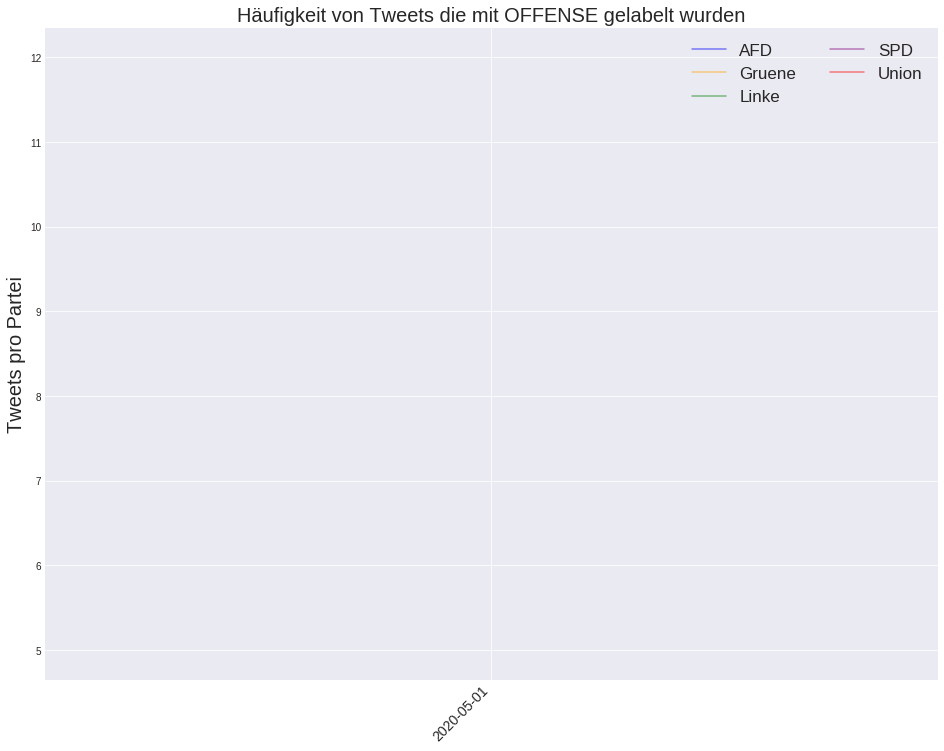

In [37]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

plt.style.use('seaborn-darkgrid')
my_palette = ['blue', 'orange', 'green', 'purple', 'red', 'black']

fig = plt.figure(figsize = (16, 12))
ax = fig.add_subplot(111)

num=0
for column in partei_piv['full_text']:
    ax.plot(partei_piv.index, partei_piv['full_text'][column], color = my_palette[num], alpha=0.5, label = column)
    num+=1

ax.plot(partei_piv.index, partei_piv['full_text']['AFD'], marker='', color='blue', linewidth=4, alpha=0.7)
#ax.plot(partei_piv.index, partei_piv['full_text']['SPD'], marker='', color='red', linewidth=4, alpha=0.7)
#ax.plot(partei_piv.index, partei_piv['full_text']['Linke'], marker='', color='purple', linewidth=4, alpha=0.7)
#ax.plot(partei_piv.index, partei_piv['full_text']['FDP'], marker='', color='orange', linewidth=4, alpha=0.7)

ax.set_title('Häufigkeit von Tweets die mit OFFENSE gelabelt wurden', size = 20)
ylab = ax.set_ylabel('Tweets pro Partei', size = 20)
# = ax.set_xlabel('Datum', size = 20)
plt.legend(loc = 1, ncol = 2, fontsize = 17)

#x_tags
x_tags = plt.xticks(partei_piv.index, fontsize = 14, rotation = 45, ha = "right")


In [ ]:
# pd.set_option('display.max_rows', 0)
pd.set_option('display.max_rows', 500)

mdp_partei = sample_df[['user_party', 'week', 'user_screen_name', 'predict']]
# mdp_partei = mdp_partei[mdp_partei['predict'] == 'OFFENSE']
partei_piv = pd.pivot_table(mdp_partei, columns = ['predict'], index = ['user_party','user_screen_name'], aggfunc = np.count_nonzero)
partei_piv

In [ ]:
sample_df[sample_df['user_screen_name'] == 'StBrandner']
#sample_df[sample_df['date'] == datetime.date(2020,2,5)]
#sample_df.loc[:,('month')] = sample_df.created_at_datetime.dt.strftime('%y-%m')
sample_df.loc[(sample_df['date'] == datetime.date(2020,5,8)) & (sample_df['user_party'] == 'AFD')]